###### Import the Required Packages


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import BatchNormalization
from keras.layers import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import joblib
import pickle as pk
from sklearn.externals.joblib import dump, load

###### Set the Path for where the Images and lables are stored

In [59]:
#Set the Path where Images and Lables are stored
path = 

#change directory to path variable
os.chdir(path)

#checking path and listing  files in directory 
#pwd
#os.listdir() 

###### Import Label CSV and Process

In [64]:
#labels = pd.read_csv("m.csv")
import pandas as pd
labels = pd.read_csv("balanced.csv")


In [65]:
#Shuffeling the data to ensure randomness 
labels= labels.sample(frac=1)
labels.set_index('0', inplace=True)
labels.head()

,cancer
0,
ISIC_0033834,1
ISIC_0000039,0
ISIC_0000216,0
ISIC_0029072,0
ISIC_0034092,1


In [66]:
#checking shape
labels.shape

(1534, 1)

###### Create X and y from Images and Labels 

In [67]:
#X and y

''' we assign y from panda series in labels dataframe
    and we assign X based on name of the file
'''
import skimage.io as io
imgs = []    

y = pd.Series(labels.cancer.values)

#img_path = 'C:\\Users\\Rob Hess\\Desktop\\testset\\svm\\scaled_cnn\\'
img_path = 'C:\\Users\\Rob Hess\\Desktop\\testset\\svm\\256_C_CNN\\'
for img in labels.index:    
    img = img + '.jpg'
    imgs.append(io.imread(os.path.join(img_path, img))) 


In [9]:
#check the shpae of X y
X =np.array(imgs)
print("X Shape is :", X.shape)
print("y Shape is :", y.shape)

X Shape is : (1534, 256, 256, 3)
y Shape is : (1534,)


In [10]:
#Split the data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=43)


In [11]:
#print the shapes of training and test data 
print("shape of train images is :", X_train.shape)
print("shape of test images is :", X_test.shape)
print("shape of train labels is :", y_train.shape)
print("shape of test labeks is :", y_test.shape)

shape of train images is : (1073, 256, 256, 3)
shape of test images is : (461, 256, 256, 3)
shape of train labels is : (1073,)
shape of test labeks is : (461,)


###### CNN parameter assignments 

In [ ]:
#Setting some varibales which will be used in CNN model
nb_train_samples = X_train.shape[0]
nb_validation_samples = X_test.shape[0]

In [13]:
#Settinig Batch size and Epochs 
#found low batch size caused more error variance, 99 seems to be sweet spot
batch_size = 99
nb_epochs = 50
input_shape = (256, 256, 3)

In [14]:
#define Model and logging 

log_name = 'keras_model_training.log'
model_name = 'keras_model.h5'
    
    
model = Sequential()
    
model.add(Conv2D(32, (3, 3), input_shape=input_shape , activation=('relu')))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(64, (3, 3) , activation=('relu')))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3) , activation=('relu')))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3) , activation=('relu')))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 256)      

In [15]:
#setting a different Learning rate found default  wasn't optimum for my data
from keras.optimizers import Adam
opt = Adam(lr=0.00001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

In [16]:
#training generator settings 
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.5,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=True)

In [18]:
#set saving of models based on best loss and acc
best_model_val_acc = ModelCheckpoint('best_model_val_acc',monitor='val_accuracy',
                                    mode = 'max', verbose=1, save_best_only=True, save_weights_only= True)
best_model_val_loss = ModelCheckpoint('best_model_val_loss',monitor='val_loss',
                                    mode = 'min', verbose=1, save_best_only=True, save_weights_only= True)

In [19]:
# early stopping to prevent overfitting
import keras
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               min_delta=0,
                                               patience=4,
                                               verbose=0,
                                               mode='auto',
                                               baseline=None,
                                               restore_best_weights=True
                                               )

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
# create csv with training data log
csv_logger = CSVLogger(log_name)


In [21]:
#fit model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=nb_epochs,
        shuffle=True,
        validation_data=test_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[csv_logger, best_model_val_acc, best_model_val_loss]
    )



Epoch 1/50
10/10 [==============================] - 11s 1s/step - loss: 0.6900 - accuracy: 0.5144 - val_loss: 0.6899 - val_accuracy: 0.5429

Epoch 00001: val_accuracy improved from -inf to 0.54293, saving model to best_model_val_acc

Epoch 00001: val_loss improved from inf to 0.68986, saving model to best_model_val_loss
Epoch 2/50
10/10 [==============================] - 11s 1s/step - loss: 0.6843 - accuracy: 0.5287 - val_loss: 0.6832 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.54293

Epoch 00002: val_loss improved from 0.68986 to 0.68321, saving model to best_model_val_loss
Epoch 3/50
10/10 [==============================] - 10s 1s/step - loss: 0.6781 - accuracy: 0.6088 - val_loss: 0.6660 - val_accuracy: 0.5718

Epoch 00003: val_accuracy improved from 0.54293 to 0.57182, saving model to best_model_val_acc

Epoch 00003: val_loss improved from 0.68321 to 0.66605, saving model to best_model_val_loss
Epoch 4/50
10/10 [==============================] - 11s 1s/s


Epoch 00029: val_loss did not improve from 0.40468
Epoch 30/50
10/10 [==============================] - 11s 1s/step - loss: 0.4883 - accuracy: 0.7912 - val_loss: 0.3824 - val_accuracy: 0.8536

Epoch 00030: val_accuracy improved from 0.85083 to 0.85359, saving model to best_model_val_acc

Epoch 00030: val_loss improved from 0.40468 to 0.38241, saving model to best_model_val_loss
Epoch 31/50
10/10 [==============================] - 11s 1s/step - loss: 0.5106 - accuracy: 0.7788 - val_loss: 0.3928 - val_accuracy: 0.8460

Epoch 00031: val_accuracy did not improve from 0.85359

Epoch 00031: val_loss did not improve from 0.38241
Epoch 32/50
10/10 [==============================] - 12s 1s/step - loss: 0.5083 - accuracy: 0.7782 - val_loss: 0.4041 - val_accuracy: 0.8398

Epoch 00032: val_accuracy did not improve from 0.85359

Epoch 00032: val_loss did not improve from 0.38241
Epoch 33/50
10/10 [==============================] - 11s 1s/step - loss: 0.4990 - accuracy: 0.7875 - val_loss: 0.3980 - 

In [29]:
#checking the layer numbers
len(model.layers)

12

In [43]:
#checking result
loss, acc = model.evaluate(X_test, y_test)
print("Model Test accuracy: {:5.2f}%".format(100*acc))

loss, acc = model.evaluate(X_train, y_train)
print("Model Train accuracy: {:5.2f}%".format(100*acc))

461/461 [==============================] - 1s 2ms/step
Model Test accuracy: 86.77%
1073/1073 [==============================] - 2s 1ms/step
Model Train accuracy: 82.48%


In [34]:
#Loading and saving model weights
# save model
model.save('robert5_lr00001_new')
#model.load_weights('robert5_lr0001')

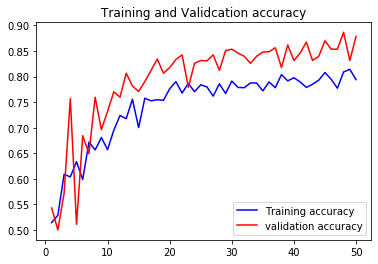

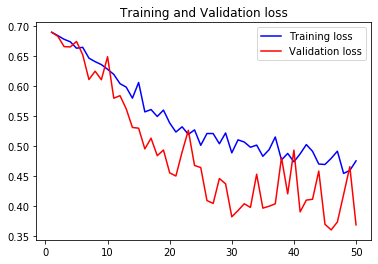

In [44]:
#lets plot
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss =history.history['val_loss']
epochs = range(1, len(acc)+1)

#train and test (valdication) accuracy
plt.plot(epochs, acc, 'b', label="Training accuracy")
plt.plot(epochs, val_acc, 'r',label='validation accuracy')
plt.title('Training and Validcation accuracy')
plt.legend()

plt.figure()
#train and test loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [36]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
yhat_train_probs=model.predict(X_train, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_train_classes= model.predict_classes(X_train, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [37]:
#mertics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Accuracy: 0.867679
Precision: 0.924324
Recall: 0.784404
F1 score: 0.848635
ROC AUC: 0.872683
[[229  14]
 [ 47 171]]


In [38]:
sensitivity1 = matrix[0,0]/(matrix[0,0]+matrix[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = matrix[1,1]/(matrix[1,0]+matrix[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.9423868312757202
Specificity :  0.7844036697247706


In [39]:
#using a confusion metrics fuctions to look at our results
#reference https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

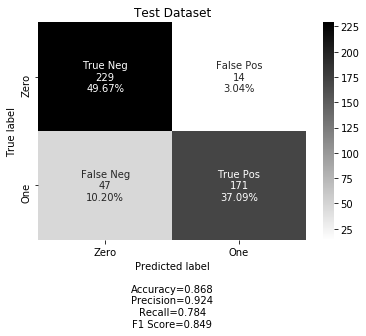

In [42]:
import seaborn as sns
#check confusion matrix for test data

cf_matrix_test=confusion_matrix(y_test, yhat_classes)
# print(confusion_matrix(y_test, y_pred))
# print(f1_score(y_test, y_pred, average='micro')) 
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']

make_confusion_matrix(matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary', title='Test Dataset')